In [2]:
#Setup and Installation
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

2025-05-14 20:02:39.800528: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 20:02:39.803801: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-14 20:02:39.811949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747252959.826539   23257 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747252959.830823   23257 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747252959.843766   23257 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
sns.set_theme()
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

2025-05-14 20:02:52.386323: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-14 20:02:52.562033: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-14 20:03:16.357991: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-14 20:03:20.519967: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


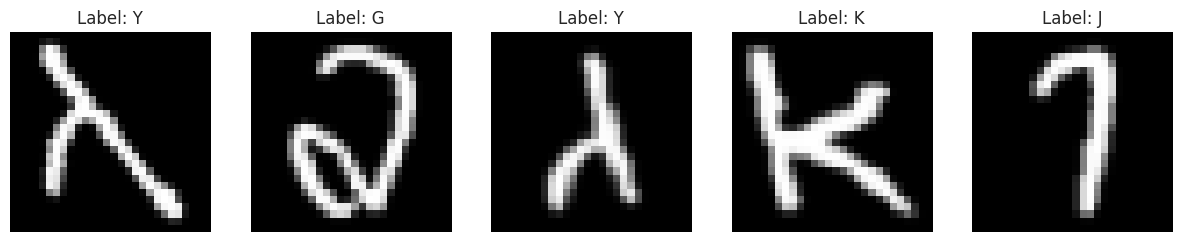

In [4]:
#Data Loading and Preprocessing
# Load EMNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True,
)

def ds_to_numpy(ds):
    images = []
    labels = []
    for img, label in tfds.as_numpy(ds):
        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)

x_train, y_train = ds_to_numpy(ds_train)
x_test, y_test = ds_to_numpy(ds_test)


# Print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# Plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    #Rotate image to the correct orientation
    img = np.flip(np.squeeze(x_train[i]).T, axis=0)
    plt.imshow(img, cmap='gray')
    plt.title(f'Label: {chr(y_train[i] + 64)}')
    plt.axis('off')
plt.show()

In [5]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape grayscale images to (28,28,1) (samples, height, width, channels)
x_train= x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (71040, 28, 28, 1)
Preprocessed validation data shape: (17760, 28, 28, 1)
Preprocessed test data shape: (14800, 28, 28, 1)


In [9]:
# Create CNN using Keras
def create_cnn_keras(input_shape, num_classes):
    """
    Create a CNN using TensorFlow/Keras.
    
    Requirements:
    - Must use at least 2 convolutional layers
    - Must include pooling and batch normalization
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 85% accuracy on test set
    - Minimize overfitting using batch normalization and dropout
    - Train efficiently with appropriate batch size and learning rate
    
    Args:
        input_shape: Shape of input data (should be (28, 28, 1) for grayscale images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([
        #First convolutional block
        tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),

        #Second convolutional block
        tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Dropout(0.25),

        #Fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        #Output
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

In [10]:
# Create and compile model
model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,602 (1.62 MB)

 Trainable params: 424,154 (1.62 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
#PyTorch implementation

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        """
        Create a CNN using PyTorch.
        
        Requirements:
        - Must use at least 2 convolutional layers
        - Must include pooling and batch normalization
        
        Goals:
        - Achieve > 85% accuracy on test set
        - Minimize overfitting using batch normalization and dropout
        - Train efficiently with appropriate batch size and learning rate
        
        Args:
            num_classes: Number of output classes (26 for letters)
        """
        super(CNN, self).__init__()
        
        #First Convolutional Block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop1 = nn.Dropout(0.25)

        #Second Convolutional Block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.drop2 = nn.Dropout(0.25)
        
        #Connected layers
        self.fc1 = nn.Linear(64*7*7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.drop3 = nn.Dropout(0.5)

        #Output layer
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
        
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)

        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Fully connected block
        x = self.fc1(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.drop3(x)

        # Output
        x = self.fc2(x)
        return x

# Create model
model = CNN(num_classes=26)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)


In [12]:
print(x_train.shape)
print(y_train.shape) 
print(x_val.shape) 
print(y_val.shape)

(71040, 28, 28, 1)
(71040, 26)
(17760, 28, 28, 1)
(17760, 26)


In [13]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]
model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)

# Train model
history_obj = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=callbacks
)

/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


2025-05-14 20:06:00.932169: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 222781440 exceeds 10% of free system memory.


555/555 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6144 - loss: 1.3599

2025-05-14 20:07:11.362438: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55695360 exceeds 10% of free system memory.


555/555 ━━━━━━━━━━━━━━━━━━━━ 76s 132ms/step - accuracy: 0.6146 - loss: 1.3590 - val_accuracy: 0.5665 - val_loss: 1.3717 - learning_rate: 0.0010
Epoch 2/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - accuracy: 0.8450 - loss: 0.4882 - val_accuracy: 0.9084 - val_loss: 0.2782 - learning_rate: 0.0010
Epoch 3/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 81s 115ms/step - accuracy: 0.8729 - loss: 0.3909 - val_accuracy: 0.9124 - val_loss: 0.2665 - learning_rate: 0.0010
Epoch 4/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 66s 118ms/step - accuracy: 0.8895 - loss: 0.3379 - val_accuracy: 0.9260 - val_loss: 0.2199 - learning_rate: 0.0010
Epoch 5/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 64s 115ms/step - accuracy: 0.8979 - loss: 0.3096 - val_accuracy: 0.9258 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 6/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 64s 115ms/step - accuracy: 0.9017 - loss: 0.2896 - val_accuracy: 0.9308 - val_loss: 0.2037 - learning_rate: 0.0010
Epoch 7/20
555/555 ━━━━━━━━━━━━━━━━━━━━ 66s 118ms/step - accuracy: 0.9074 - loss:

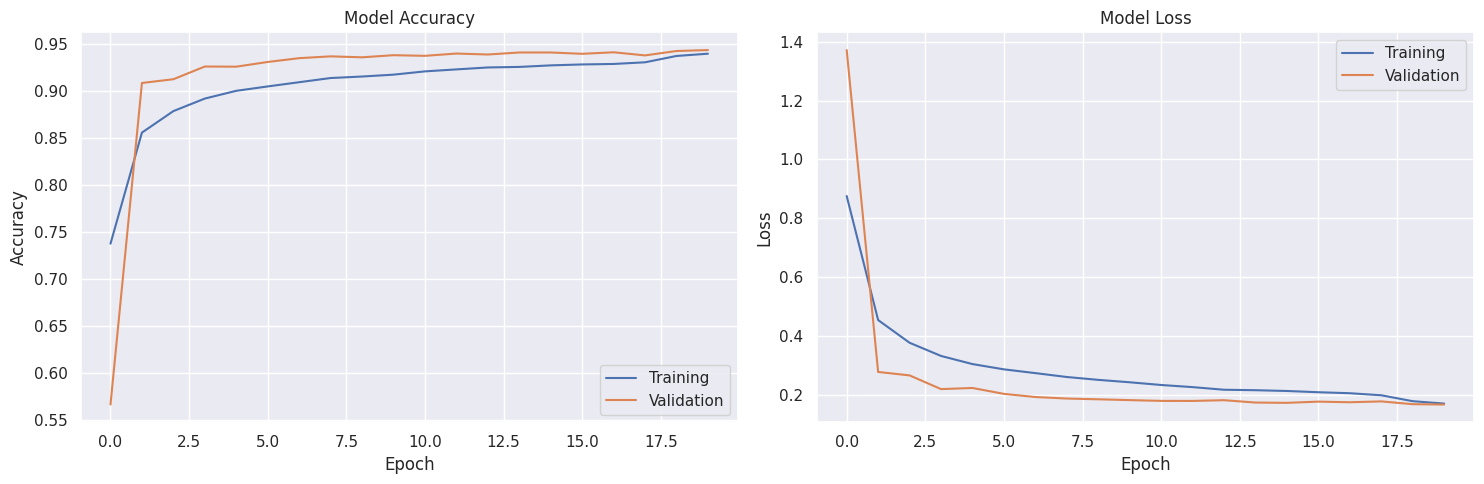

In [14]:

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history_obj.history['accuracy'], label='Training')
ax1.plot(history_obj.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history_obj.history['loss'], label='Training')
ax2.plot(history_obj.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

In [15]:
with open("results/part_2/cnn_keras_metrics.txt", "w") as f:
    f.write("Model Evaluation Metrics:\n")
    f.write(f"Final Training Accuracy: {history_obj.history['accuracy'][-1]:.4f}\n")
    f.write(f"Final Validation Accuracy: {history_obj.history['val_accuracy'][-1]:.4f}\n")
    f.write(f"Final Training Loss: {history_obj.history['loss'][-1]:.4f}\n")
    f.write(f"Final Validation Loss: {history_obj.history['val_loss'][-1]:.4f}\n")

print(f"Final Training Accuracy: {history_obj.history['accuracy'][-1]:.4f}\n")
print(f"Final Validation Accuracy: {history_obj.history['val_accuracy'][-1]:.4f}\n")
print(f"Final Training Loss: {history_obj.history['loss'][-1]:.4f}\n")
print(f"Final Validation Loss: {history_obj.history['val_loss'][-1]:.4f}\n")

Final Training Accuracy: 0.9396

Final Validation Accuracy: 0.9435

Final Training Loss: 0.1707

Final Validation Loss: 0.1675

